In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/90+_DaysPastDue/90+DPD_files")

train = pd.read_csv("FITB_train.csv", na_values=["", "NA"])

test = pd.read_csv("FITB_test.csv", na_values=["", "NA"])

check the distributions

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

features = ["feature_1", "feature_2", "feature_3", "feature_4"]

plt.figure(figsize=(10, 6), dpi=300)  # High-quality figure

# Create boxplot
train[features].boxplot(grid=False, vert=False)
plt.title("Boxplots of Features")
plt.xlabel("Value")
plt.ylabel("Features")
plt.show()

feature 3 has an outragious right tail.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

features = ["feature_1", "feature_2", "feature_3", "feature_4"]

# Convert data to long format for Seaborn
data_long = train[features].melt(var_name="Feature", value_name="Value")

plt.figure(figsize=(10, 6), dpi=300)  # High-quality figure
sns.violinplot(x="Value", y="Feature", data=data_long, scale="width")
plt.title("Violin Plots of Features")
plt.xlabel("Value")
plt.ylabel("Features")
plt.show()

yep, we gotta take care of feature 3 for training

In [ ]:
threshold = train['feature_3'].quantile(0.99)

train.loc[train['feature_3'] > threshold, 'feature_3'] = pd.NA

print(train['feature_3'])

In [ ]:
features = ["feature_1", "feature_2", "feature_3", "feature_4"]

# Convert data to long format for Seaborn
data_long = train[features].melt(var_name="Feature", value_name="Value")

plt.figure(figsize=(10, 6), dpi=300)  # High-quality figure
sns.violinplot(x="Value", y="Feature", data=data_long, scale="width")
plt.title("Violin Plots of Features")
plt.xlabel("Value")
plt.ylabel("Features")
plt.show()

this is acceptable, replace the missing values with median 

In [ ]:
median_value = train['feature_3'].median()

train['feature_3'].fillna(median_value, inplace=True)

train.rename(columns={'feature_3': 'feature_3_impute'}, inplace=True)



median_value = test['feature_3'].median()

test['feature_3'].fillna(median_value, inplace=True)

test.rename(columns={'feature_3': 'feature_3_impute'}, inplace=True)


sort by ID and date so that if feature 2 is missing we can replace it with the next year or the previous years value

In [ ]:
train['date'] = pd.to_datetime(train['date']).dt.year
test['date'] = pd.to_datetime(test['date']).dt.year

def impute_feature_2(df):
    df = df.sort_values(by=['id', 'date'])  
    df['feature_2'] = df['feature_2'].fillna(method='bfill') 
    df['feature_2'] = df['feature_2'].fillna(method='ffill') 
    return df

train = train.groupby('id', group_keys=False).apply(impute_feature_2)
test = test.groupby('id', group_keys=False).apply(impute_feature_2)

train.rename(columns={'feature_2': 'feature_2_impute'}, inplace=True)
test.rename(columns={'feature_2': 'feature_2_impute'}, inplace=True)

train = train.dropna(subset=['feature_2_impute'])
test = test.dropna(subset=['feature_2_impute'])

display(train.head())

Normalize our features for the model 

,feature_1_standard,feature_2,feature_3,feature_4_standard,id,date,y
0,39.165085,60.253765,137.986051,-35.462685,50501,2000-12-31,0
1,-12.614289,57.959237,126.212293,44.420647,50501,2001-12-31,1
2,0.043813,-39.293907,138.687175,64.944112,50501,2002-12-31,0
3,2.296984,49.996686,123.782456,-3.587873,50501,2003-12-31,0
4,7.188897,-83.533230,150.102046,95.359641,50501,2004-12-31,0
...,...,...,...,...,...,...,...
3936,37.404213,82.740386,135.415762,-41.797518,50820,2012-12-31,0
3937,-41.998683,118.029225,113.602038,65.019912,50820,2013-12-31,1
3938,23.476915,53.978062,145.438067,35.848482,50820,2014-12-31,0
3939,74.362219,161.320617,163.350476,-14.407989,50820,2015-12-31,0


,feature_1,feature_2,feature_3,feature_4,id,date,y
0,2.595327,-32.891072,136.591557,49.620272,50821,2000-12-31,0
1,-5.560043,24.061365,112.975910,-30.343529,50821,2001-12-31,0
2,-50.197941,-24.986282,82.180471,-50.341907,50821,2002-12-31,0
3,89.590337,132.682123,169.336698,-27.406673,50821,2003-12-31,0
4,-22.253535,-72.280530,125.969360,66.272859,50821,2004-12-31,0
...,...,...,...,...,...,...,...
1054,709.178403,178.731833,191.995244,-61.412948,50901,2000-12-31,0
1055,0.541038,22.097372,118.980328,-20.016391,50901,2001-12-31,0
1056,38.258174,8.114327,162.322692,70.443053,50901,2002-12-31,0
1057,17.717661,55.971356,123.899602,-41.830166,50901,2003-12-31,0


/var/folders/2y/cbtx_pl154qczd091zb0d4z40000gn/T/ipykernel_7091/2270975544.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['binned', categorical_var]).size().reset_index(name='count')


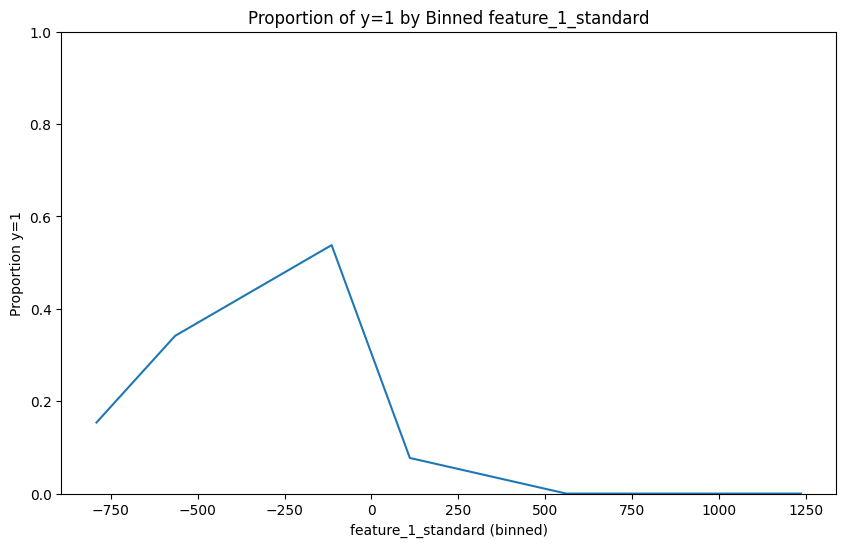

KeyError: 'feature_2_standard'

In [4]:

train.rename(columns={
    'feature_1': 'feature_1_standard',
    'feature_2_impute': 'feature_2_standard',
    'feature_3_impute': 'feature_3_standard',
    'feature_4': 'feature_4_standard'
}, inplace=True)

train['y'] = train['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)
test['y'] = test['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)

display(train)
display(test)


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_proportion_positive(df, continuous_var, categorical_var='y', positive_value=1, bins=10):
    # Create bins for the continuous variable
    df['binned'] = pd.cut(df[continuous_var], bins=bins)

    # Group by the binned variable and the category to get counts
    grouped = df.groupby(['binned', categorical_var]).size().reset_index(name='count')
    
    # Pivot so that each bin is a row and categories form columns
    # This will give something like:
    # binned          0    1
    # (x0, x1]       x    y
    pivot = grouped.pivot(index='binned', columns=categorical_var, values='count').fillna(0)

    # Calculate total and positive counts for each bin
    total_count = pivot.sum(axis=1)
    positive_count = pivot[positive_value]
    
    # Compute the proportion of positive outcomes
    proportion_positive = positive_count / total_count

    # Create a DataFrame for plotting
    # Extract bin centers from the intervals
    plot_df = pd.DataFrame({
        'bin_center': pivot.index.map(lambda interval: interval.mid),
        'proportion_positive': proportion_positive
    })

    # Plot the proportion of positive outcomes by bin
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='bin_center', y='proportion_positive', data=plot_df)
    plt.title(f'Proportion of {categorical_var}={positive_value} by Binned {continuous_var}')
    plt.xlabel(f"{continuous_var} (binned)")
    plt.ylabel(f"Proportion {categorical_var}={positive_value}")
    plt.ylim(0, 1)  # proportions range from 0 to 1
    plt.show()


plot_proportion_positive(train, 'feature_1_standard', 'y', positive_value=1, bins=10)
plot_proportion_positive(train, 'feature_2_standard', 'y', positive_value=1, bins=10)
plot_proportion_positive(train, 'feature_3_standard', 'y', positive_value=1, bins=10)
plot_proportion_positive(train, 'feature_4_standard', 'y', positive_value=1, bins=10)



In [ ]:
features = ['feature_1_standard', 'feature_2_standard', 'feature_3_standard', 'feature_4_standard']


for feature in features:
    train[feature] = (train[feature] - train[feature].mean(skipna=True)) / train[feature].std(skipna=True)


train.rename(columns={
    'feature_1_standard': 'feature_1_standard',
    'feature_2_standard': 'feature_2_standard',
    'feature_3_standard': 'feature_3_standard',
    'feature_4_standard': 'feature_4_standard'
}, inplace=True)


for feature in features:
    test[feature] = (test[feature] - test[feature].mean(skipna=True)) / test[feature].std(skipna=True)


test.rename(columns={
    'feature_1_standard': 'feature_1_standard',
    'feature_2_standard': 'feature_2_standard',
    'feature_3_standard': 'feature_3_standard',
    'feature_4_standard': 'feature_4_standard'
}, inplace=True)


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_proportion_positive(df, continuous_var, categorical_var='y', positive_value=1, bins=50):
    # Create bins for the continuous variable
    df['binned'] = pd.cut(df[continuous_var], bins=bins)

    # Group by the binned variable and the category to get counts
    grouped = df.groupby(['binned', categorical_var]).size().reset_index(name='count')
    
    # Pivot so that each bin is a row and categories form columns
    pivot = grouped.pivot(index='binned', columns=categorical_var, values='count').fillna(0)

    # Calculate total and positive counts for each bin
    total_count = pivot.sum(axis=1)
    positive_count = pivot[positive_value]
    
    # Compute the proportion of positive outcomes
    proportion_positive = positive_count / total_count

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'bin_center': pivot.index.map(lambda interval: interval.mid),
        'proportion_positive': proportion_positive
    })

    # Plot the proportion of positive outcomes by bin with points
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='bin_center', y='proportion_positive', data=plot_df, color='blue', s=50)

    # Add a smoother line using lowess
    sns.regplot(x='bin_center', y='proportion_positive', data=plot_df, 
                scatter=False, lowess=True, color='red', line_kws={'lw':2})

    plt.title(f'Proportion of {categorical_var}={positive_value} by Binned {continuous_var}')
    plt.xlabel(f"{continuous_var} (binned)")
    plt.ylabel(f"Proportion {categorical_var}={positive_value}")
    plt.ylim(0, 1)
    plt.show()


plot_proportion_positive(train, 'feature_1_standard', 'y', positive_value=1, bins=50)
plot_proportion_positive(train, 'feature_2_standard', 'y', positive_value=1, bins=50)
plot_proportion_positive(train, 'feature_3_standard', 'y', positive_value=1, bins=50)
plot_proportion_positive(train, 'feature_4_standard', 'y', positive_value=1, bins=50)

build a logistic regression model 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


x_train = train[['feature_1_standard', 'feature_2_standard', 'feature_3_standard', 'feature_4_standard']] #training predictor

y_train = train['y'] # training response 

x_test = test[['feature_1_standard', 'feature_2_standard', 'feature_3_standard', 'feature_4_standard']] #test predictor

y_test = test[['y']] # test response 

model = LogisticRegression()
model.fit(x_train, y_train) # train the model on predictor and response from training data 


y_pred = model.predict(x_test) # evaluate model on test predictors for predicted binary outcome 

y_pred_prob = model.predict_proba(x_test)  # evaluate model on test data for coresponding probabilities of predicted outcome 

test['prob'] = y_pred_prob[:,1] # appending the probability posative outcome column to test for evaluation of ROC curve 


print(classification_report(y_test, y_pred)) # compair actual test response with predicted test response 

KeyError: "['feature_2_standard', 'feature_3_standard'] not in index"

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np


fpr, tpr, thresholds = roc_curve(test['y'], test['prob'])

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))

roc_curve = plt.plot(fpr, tpr)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Assuming test['y'] is the ground truth labels and test['prob'] is the predicted probabilities
fpr, tpr, thresholds = roc_curve(test['y'], test['prob'])

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random guess')  # Add diagonal for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()